### 配置spark环境变量

In [1]:
import sys,os
import pandas as pd
import csv
# from pyspark import SparkConf
os.environ['SPARK_HOME'] = "D:/py包/spark-2.3.3-bin-hadoop2.7"
sys.path.append("D:/py包/spark-2.3.3-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip")
sys.path.append("D:/py包/spark-2.3.3-bin-hadoop2.7/bin")
sys.path.append("D:/py包/spark-2.3.3-bin-hadoop2.7/python")
sys.path.append("D:/py包/spark-2.3.3-bin-hadoop2.7/python/pyspark")
sys.path.append("D:/py包/spark-2.3.3-bin-hadoop2.7/python/lib")
sys.path.append("D:/py包/spark-2.3.3-bin-hadoop2.7/python/lib/pyspark.zip")
sys.path.append("C:/Program Files/Java/jdk1.8.0_60")

### 定义课程名称和id

In [15]:
course_name='Python'
course_id=32

### 将csv中的每一节课程中的内容读取，然后转化成list格式

In [3]:
def read_data_to_list(course_name,course_id):
    
    filename_list=os.listdir(str(course_id)+'-'+course_name)
#     print(filename_list)
    all_knowledge_list=[]
    
    for index,section in enumerate(filename_list):
        file_path = os.path.join(str(course_id)+'-'+course_name,section)
        # file_path='66-PHP经典课程'+'/'+'PHP经典课程-PHP-C12 Linux.csv'
        # file_path='32-Python'+'/'+'Python-语句结构.csv'
#         print(file_path)

        data = open(file_path, 'r', encoding='utf-8')
        lists = csv.reader(data)
        
        actor_list = []
        for names in lists:

            if len(names) == 0:
                continue


            actor_list.append(names)
        all_knowledge_list.append(actor_list)

    return index+1,all_knowledge_list,filename_list

### fp_growth算法关联性处理，输出频繁项集和次数，以及关联性强的组合(和组合的支持度，置信度，提升度)

In [4]:
def fp_growth_deal(data_lists,list_len, minSupport=0.5, minConfidence=0.6):
        from pyspark.ml.fpm import FPGrowth
        from pyspark.sql import SparkSession
        from pyspark.sql import functions as F

        spark = SparkSession.builder.appName("FrequentPatternMiningExample").getOrCreate()
        for i in range(list_len):

            new_data_list=data_lists[i]
#             print('data_list[i]: ',data_list[i])
            # 有效知识点的长度(非空)
            data_len = len(new_data_list)

            data_id = [i for i in range(data_len)]
            # print(id)

            dict={'id': data_id,'items':new_data_list}
            # print(dict)

            new_data=pd.DataFrame(data=dict,columns=['id','items'])
            df = spark.createDataFrame(new_data)

#             print(df.collect())

            fpGrowth = FPGrowth(itemsCol="items", minSupport=minSupport, minConfidence=minConfidence)
            model = fpGrowth.fit(df)

            df_freq = model.freqItemsets
            df_ar = model.associationRules

            total = data_len
            df_supp = df_freq.withColumn("support", df_freq.freq / total)
            df_supp_ar = df_ar.join(df_supp, df_supp.items == df_ar.consequent, 'left').drop('items')
            df_lift = df_supp_ar.withColumn("lift", df_supp_ar.confidence / df_supp_ar.support)

            # df_freq_new = df_freq.withColumn('items', F.concat_ws(',', 'items'))
            df_lift_new = df_lift.withColumn('antecedent', F.concat_ws(',', 'antecedent')).withColumn('consequent',F.concat_ws(',','consequent'))
            # Display frequent itemsets.
            model.freqItemsets.show(500, False)

            # Display generated association rules.
            # model.associationRules.show(500, False)


            df_lift_new.show(500, False)

            # reform根据所有关联规则检查输入项并总结
            # 结果作为预测
            # model.transform(df).show(500, False)
            return df_lift_new,model

### 开始任务前分析文件中的内容 输出课程信息、数据条目、每个小节特征数量

In [16]:
list_len,data_lists,filename_list=read_data_to_list(course_name=course_name,course_id=course_id)

print('课程名称：',course_name)
print('\n')

for section_index,i in enumerate(filename_list):
    check_dic={} 
    k=1
    for index,value in enumerate(data_lists[section_index]):
        for v in value:
            k+=1
            check_dic[k]=''.join(v)
    print("第%s小节  名称：%s            样本个数：%s        特征数量：%s"%(section_index,i.strip('.csv'),len(data_lists[section_index]),len(set(check_dic.values()))))

print('\n')
print('一共有%s个小节'%(len(filename_list)))

课程名称： Python


第0小节  名称：Python-Python初识            样本个数：31        特征数量：1
第1小节  名称：Python-函数            样本个数：26        特征数量：2
第2小节  名称：Python-变量            样本个数：21        特征数量：1
第3小节  名称：Python-基础类型            样本个数：32        特征数量：2
第4小节  名称：Python-数据结构            样本个数：38        特征数量：4
第5小节  名称：Python-模块            样本个数：27        特征数量：2
第6小节  名称：Python-语句结构            样本个数：35        特征数量：4
第7小节  名称：Python-输入与输出            样本个数：18        特征数量：1
第8小节  名称：Python-运算符            样本个数：26        特征数量：2
第9小节  名称：Python-迭代器与生成器            样本个数：27        特征数量：2
第10小节  名称：Python-面向对象            样本个数：37        特征数量：4


一共有11个小节


### 不同数据条目验证

In [ ]:
# k=1
# check_dic={} 
# for index,value in enumerate(data_lists[0]):
# #     print( index,value)
#     for v in value:
#         k+=1

#         print(k,v)
#         check_dic[k]=''.join(v)
        
# print(len(set(check_dic.values())))
# print(set(check_dic.values()))

### 定义输出第几小节，然后进行模型训练，计算关联性

In [17]:
# 模型训练输出结果
# fp_growth_deal(data_lists=data_lists,list_len=list_len, minSupport=0.1, minConfidence=0.5)

# 定义输出的课程中的第几小节
section=6
data_list=data_lists[section:section+1]


print('现在开始计算 "%s" 中 "%s" 小节知识点关联度.....'%(course_name,filename_list[section].strip('.csv')))

# 模型训练，计算关联性
df_lift_new,model=fp_growth_deal(data_lists=data_list,list_len=1, minSupport=0.1, minConfidence=0.5)

现在开始计算 "Python" 中 "Python-语句结构" 小节知识点关联度.....
+---------------------+----+
|items                |freq|
+---------------------+----+
|[循环结构1]              |20  |
|[分支结构1]              |19  |
|[分支结构1, 循环结构1]       |10  |
|[循环结构2]              |17  |
|[循环结构2, 分支结构1]       |11  |
|[循环结构2, 分支结构1, 循环结构1]|6   |
|[循环结构2, 循环结构1]       |10  |
|[分支结构2]              |15  |
|[分支结构2, 循环结构2]       |7   |
|[分支结构2, 循环结构2, 分支结构1]|5   |
|[分支结构2, 循环结构2, 循环结构1]|5   |
|[分支结构2, 分支结构1]       |8   |
|[分支结构2, 分支结构1, 循环结构1]|4   |
|[分支结构2, 循环结构1]       |7   |
+---------------------+----+

+-----------+----------+------------------+----+-------------------+------------------+
|antecedent |consequent|confidence        |freq|support            |lift              |
+-----------+----------+------------------+----+-------------------+------------------+
|循环结构1      |分支结构1     |0.5               |19  |0.5428571428571428 |0.9210526315789475|
|循环结构2      |分支结构1     |0.6470588235294118|19  |0.5428571428571428 |1.191950464

### 提取某一列数据 格式为上面输出一列中的格式

In [18]:
# df_lift_new.select('antecedent').show(500)

### 搜索出模型中的数据 格式为Row[] 列表形式

In [19]:
data=df_lift_new.select('antecedent','consequent','confidence').collect()

### 正则化提取测试

In [20]:
# for i in data:
#     i=str(i)
#     antecedent=re.search(r'=(.+), consequent',i)
#     print('antecedent',antecedent.group(1))
#     consequent=re.search(r'consequent=(.+), confidence',i)
#     print('consequent',consequent.group(1))
#     confidence=re.search(r'confidence=(.+)\)',i)
#     print('confidence',confidence.group(1))
#     print('***'*20)

### 正则 取到计算模型后的三个指标参数值 分别为 节点(antecedent，consequent) 权重(confidence)

In [21]:
import re

In [22]:
# 因为关联性分析存在A->B 也可能存在着B->A 这样的情况，虽然指向相反，但是置信度却可能不同 所以这里单独取出画图
new_antecedent_lists1=[]
new_consequent_lists1=[]
new_weight_lists1=[]

new_antecedent_lists2=[]
new_consequent_lists2=[]
new_weight_lists2=[]

sign=1
new_sign=1

for index,i in enumerate(data):
    i=str(i)
    # 以下三行为使用正则提取每行数据中的antecedent，consequent，confidence这三个指标参数
    antecedent=re.search(r'=(.+), consequent',i).group(1)
    consequent=re.search(r'consequent=(.+), confidence',i).group(1)
    confidence=re.search(r'confidence=(.+)\)',i).group(1)
    
    # 如果new_antecedent_lists1和new_consequent_lists1中有数据就开始匹配
    if len(new_antecedent_lists1) > 0 and len(new_consequent_lists1) > 0:
        for ant_con in zip(new_antecedent_lists1,new_consequent_lists1):
#           交叉匹配因为每一条数据都是不重复的，所以我们不需要管一个列表中是否存在相同的知识点，而是要查询两个列表中是否存在相反(a->b b->a)这样的知识点
#           所以antecedent匹配new_consequent_lists1列表，consequent匹配new_antecedent_lists1列表，如果两个条件都满足则这个对应知识点(a,b)为重复知识点，将其加到list2中
            if antecedent == ant_con[1] and consequent == ant_con[0]:
#                 print(ant_con[1],ant_con[0])
                new_antecedent_lists2.append(antecedent)
                new_consequent_lists2.append(consequent)
                new_weight_lists2.append(confidence)
                new_sign=sign+1
                break
               
        if sign >=new_sign:      
#             print('index=%s，sign=%s,new_sign=%s,开始执行list1.append'%(index,sign,new_sign)) 
            new_antecedent_lists1.append(antecedent)
            new_consequent_lists1.append(consequent)
            new_weight_lists1.append(confidence)

        else:
            sign=new_sign
        

    else:
        new_antecedent_lists1.append(antecedent)
        new_consequent_lists1.append(consequent)
        new_weight_lists1.append(confidence)

        
# print(new_antecedent_lists1)
# print(new_consequent_lists1)
# print(new_antecedent_lists2)
# print(new_consequent_lists2)

# print(len(new_antecedent_lists1))
# print(len(new_consequent_lists1))
# print(len(new_antecedent_lists2))
# print(len(new_consequent_lists2))

### 关系图可视化 相关包导入

In [23]:
import networkx as nx
import pandas as pd
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt

### 关系图可视化

In [24]:
# 画网络图：layout是我们要话的网络图的布局，spring_laout表示呈中心放射状的图
def show_graph(graph,layout='spring_layout'):
    plt.rcParams['font.sans-serif']=['SimHei']
    plt.figure(figsize=(17,8))
    if layout=="circular_layout":
        positions=nx.circular_layout(graph)
    else:
        positions=nx.spring_layout(graph)
    # 设置网络图的节点大小，大小和pagerank的值相关，因为PageRank的值很小所以我们乘上20000
    # x是pagerank的值，v是名字，是因为下面设置了 nx.set_node_attributes(graph, name = 'pagerank', values=pagerank)
    # data=True 如果为True，则将整个节点属性dict返回为（n，ddict）。如果为False，则仅返回节点n。
    nodesize=[x['pagerank']*20000 for v,x in graph.nodes(data=True)]
    # 设置网络图的边长度 根据权重值设置边长 np.sqrt表示数组各个元素的平方根
    edgesize=[np.sqrt(e[2]['weight']) for e in graph.edges(data=True)]
    # 绘制节点
    nx.draw_networkx_nodes(graph,positions,node_size=nodesize,alpha=0.4)
    # 绘制边
    nx.draw_networkx_edges(graph,positions,edge_size=edgesize,alpha=0.2)
    # 绘制节点的label
    nx.draw_networkx_labels(graph,positions,font_size=10)
    # 输出关系图
    plt.show()

### 正向关系节点、权重定义

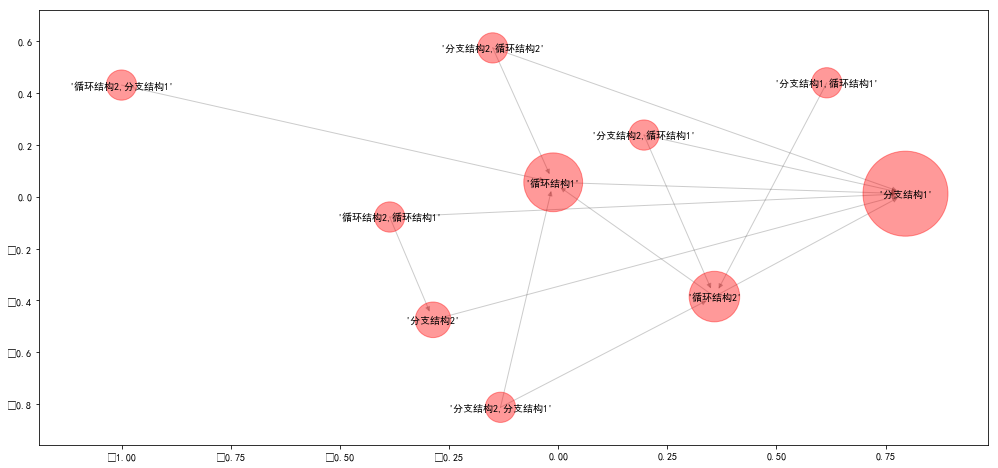

In [25]:
# defaultdict类的初始化函数接受一个类型作为参数，当所访问的键不存在的时候，可以实例化一个值作为默认值,否则访问报错，list的默认值是[],int的默认值是0
edge_weights_temp=defaultdict(int)
# 发件人MetadataFrom 收件人MetadataTo 内容RawText
for row in zip(new_antecedent_lists1,new_consequent_lists1,new_weight_lists1):
    temp=(row[0],row[1])
    edge_weights_temp[temp]=float(row[2])

# 转化格式刚刚我们定义edge_weights_temp的时候里面的数据是这样的((row[0],row[1]),weight)
edge_weights=[(key[0],key[1],val) for key,val in edge_weights_temp.items()]

# print(edge_weights)
# print(type(edge_weights[0][0]))
# print(type(edge_weights[0][1]))
# print(type(edge_weights[0][2]))



# 创建有向图
graph=nx.DiGraph()

# 设置有向边的路径和权重(from,to,weight)
graph.add_weighted_edges_from(edge_weights)

# 计算每一个点的pagerank值，并作为pagerank属性
pagerank=nx.pagerank(graph)

# 将pagerank值作为节点的属性
nx.set_node_attributes(graph,name='pagerank',values=pagerank)

# 画网络图
show_graph(graph)

### 反向关系节点、权重定义

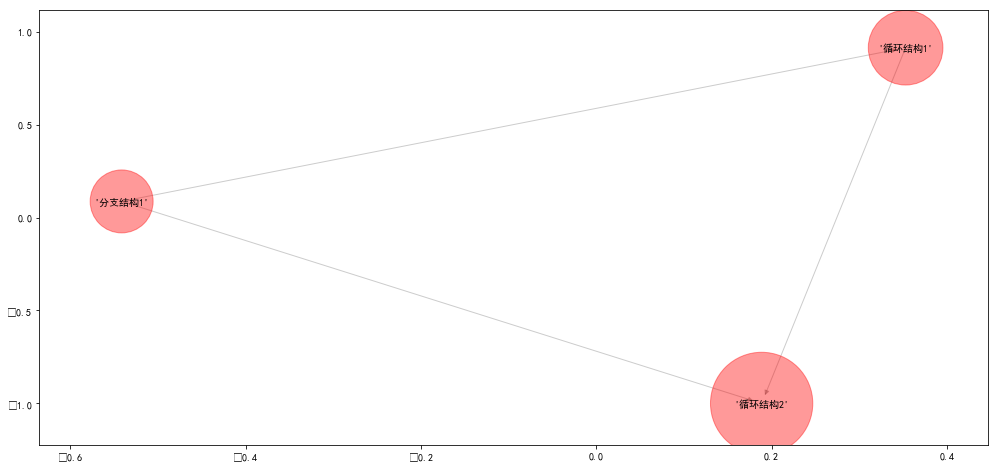

In [26]:
edge_weights_temp=defaultdict(int)
# 发件人MetadataFrom 收件人MetadataTo 内容RawText
for row in zip(new_antecedent_lists2,new_consequent_lists2,new_weight_lists2):
    temp=(row[0],row[1])
    edge_weights_temp[temp]=float(row[2])

# 转化格式刚刚我们定义edge_weights_temp的时候里面的数据是这样的((row[0],row[1]),weight)
edge_weights=[(key[0],key[1],val) for key,val in edge_weights_temp.items()]

# 创建有向图
graph=nx.DiGraph()

# 设置有向边的路径和权重(from,to,weight)
graph.add_weighted_edges_from(edge_weights)

# 计算每一个点的pagerank值，并作为pagerank属性
pagerank=nx.pagerank(graph)

# 将pagerank值作为节点的属性
nx.set_node_attributes(graph,name='pagerank',values=pagerank)

# 画网络图
show_graph(graph)